# Airline Sentiment Analysis

As a business changes, so do their customer interests and sentiments. Businesses can use sentiment analysis to track customer sentiment when launching a new product or changing the price of their products. Tracking sentiment analysis can help businesses improve products and services. Twitter is a great way to gather sentiment from customers because the platform was created to communicate and stay connected through the exchange of quick, frequent messages. Using Twitter is a great way to keep track of customer sentiment about your product, service, or business on social media. It also can help detect angry customers or negative comments. A business can use this for marketing. Using Twitter for your sentiment analysis can provide valuable insights that drive business decisions. What do customers like about your business? What do customers hate or love about your products? A business can also use this for customer support. When a model can predict if a tweet is positive or negative, a bot can respond with an appropriate message to help a customer. My goal is to gather the sentiment analysis of a variety of airlines. 

## Table of Contents:
* [Data Collection](#DataCollection)
* [Data Wrangling](#DataWrangling)
* [EDA](#EDA)
    * [Word Count](#wordcount)
    * [Predictive Words](#pw)
    * [Predictive Words by Airline](#pwa)
    * [Date vs Airline Sentiment](#Date)
    * [User Timezone](#user_timezone)
* [Conclusion](#Conclusion) 

In [1]:
### imports ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
import re

from nltk.stem import WordNetLemmatizer
from emoji import UNICODE_EMOJI
import emoji
from string import digits

import nltk ### using the Natural Language Toolkit ###
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. Data Collection <a class="anchor" id="DataCollection"></a>

In [2]:
### get data ###
tweets = pd.read_csv("../Data/Tweets.csv")

# 2. Data Wrangling <a class="anchor" id="DataWrangling"></a>

### Make functions for later use.

## Proportion of Uppercase Text in Tweet

In [3]:
def wordUpper(text):
    return sum(map(str.isupper, text)) / len(text)

tweets["uppercase"] = tweets["text"].apply(lambda x: wordUpper(x))

tweets.head(3)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   
2            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   

   uppercase  
0   0.085714  
1   0.027778  
2   0.070423

## Check if text has emoji

In [4]:
def checkEmoji(text):
    has_emoji = bool(emoji.get_emoji_regexp().search(text))
    return has_emoji
    

tweets["emoji"] = tweets["text"].apply(lambda x: checkEmoji(x))

tweets.head(3)

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_95736/3722154856.py:2: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  has_emoji = bool(emoji.get_emoji_regexp().search(text))


tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   
2            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   

   uppercase  emoji  
0   0.085714  False  
1   0.027778  False  
2   0.070423  False

## Text Preprocess

The following needs to be done to preprocess the data:

1. Make text lowercase
2. Removing punctuations, URLs, names
3. Tokenization
4. Removing stopwords ("this", "is", etc.)
4. Lemmatizing

In [5]:
### drop columns of >= 90% null values ###
tweets = tweets.drop(columns=["airline_sentiment_gold" , "negativereason_gold", "tweet_coord"])

### remove tweet_id duplicates ###
tweets = tweets.drop_duplicates(subset=["tweet_id"], keep=False) 

In [6]:
### Lowercase ###

tweets["text"] =[x.lower() for x in tweets.text]

### remove numbers ###
tweets["text"] = tweets["text"].str.replace('\d+', '', regex=True)

### REMOVE PUNCTUATIONS ###
def remove_punc(text):
    words_wo_punct = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    return words_wo_punct

tweets["text"] = tweets["text"].apply(lambda x: remove_punc(x))

In [7]:
### REMOVE WHITESPACE ###
tweets["text"] = tweets["text"].str.strip()

### remove emoji ###
tweets["text"] = tweets["text"].apply(lambda x: emoji.demojize(x))
tweets["text"].head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercials to ...
2    virginamerica i didnt today must mean i need t...
3    virginamerica its really aggressive to blast o...
4    virginamerica and its a really big bad thing a...
Name: text, dtype: object

In [8]:
### LEMMATIZING ###
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    word_list = nltk.word_tokenize(text)
    lem_text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lem_text

tweets["text"] = tweets["text"].apply(lambda x: word_lemmatizer(x))
tweets.text.head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercial to t...
2    virginamerica i didnt today must mean i need t...
3    virginamerica it really aggressive to blast ob...
4    virginamerica and it a really big bad thing ab...
Name: text, dtype: object

In [9]:
### REMOVE STOPWORDS and tokenize ###
def remove_stopwords(text):
    tokens = word_tokenize(text)
    english_stopwords = stopwords.words('english')
    tokens_wo_stopwords = [t for t in tokens if t not in english_stopwords]
    
    return tokens_wo_stopwords

tweets["text"] = tweets["text"].apply(lambda x: remove_stopwords(str(x)))
tweets["text"].head()

0                      [virginamerica, dhepburn, said]
1    [virginamerica, plus, youve, added, commercial...
2    [virginamerica, didnt, today, must, mean, need...
3    [virginamerica, really, aggressive, blast, obn...
4             [virginamerica, really, big, bad, thing]
Name: text, dtype: object

# 3. EDA <a class="anchor" id="EDA"></a>

## View distribution of sentiment

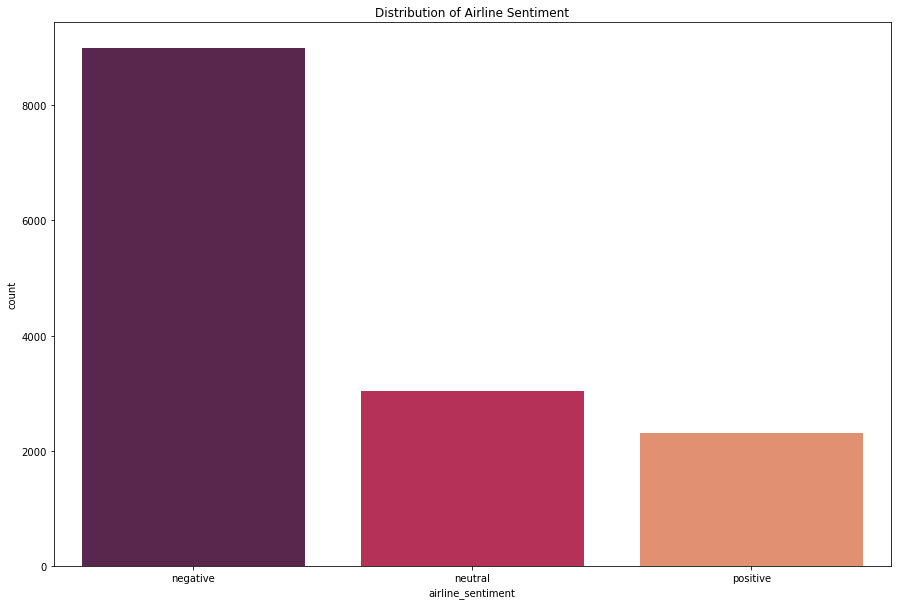

In [10]:
fig, axes = plt.subplots(figsize=(15,10))
axes = sns.countplot(x = tweets["airline_sentiment"], palette='rocket', 
                  order = tweets["airline_sentiment"].value_counts().index,
                  data = tweets).set(
                  title="Distribution of Airline Sentiment")

#### View the polarity of a tweet 

In [11]:
from textblob import TextBlob, Word, Blobber
tweets['polarity']=tweets['text'].map(lambda text: TextBlob(str(text)).sentiment.polarity)
tweets.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline        name  \
0            NaN                        NaN  Virgin America     cairdin   
1            NaN                     0.0000  Virgin America    jnardino   
2            NaN                        NaN  Virgin America  yvonnalynn   
3     Bad Flight                     0.7033  Virgin America    jnardino   
4     Can't Tell                     1.0000  Virgin America    jnardino   

   retweet_count                                               text  \
0              0                    [virginamerica, dhepburn, said]   
1              0  [virginamerica, plus, youve, added, commercial...   
2              0  [virginamerica, didnt, today, must, mean, need...   
3              0  [virginamerica, really, aggressive, blast, obn...   
4              0           [virginamerica, really, big, bad, thing]   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   

   uppercase  emoji  polarity  
0   0.085714  False   0.00000  
1   0.027778  False   0.00000  
2   0.070423  False  -0.31250  
3   0.015873  False   0.00625  
4   0.036364  False  -0.35000

#### View the distribution of the polarity of the tweet

Text(0.5, 1.0, 'Distibution of polarity')

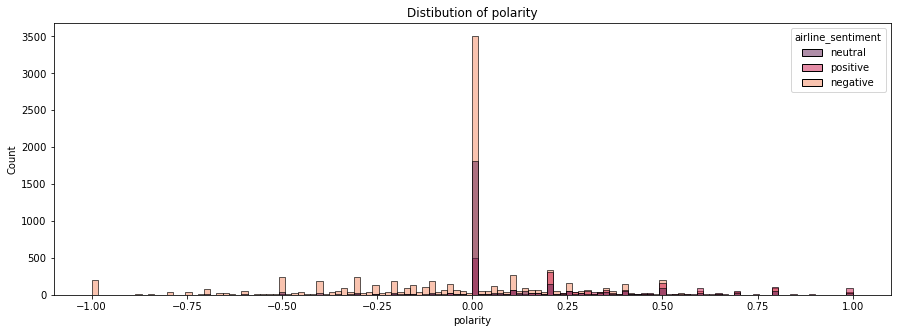

In [12]:
fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.histplot(x = tweets["polarity"], palette="rocket", hue=tweets["airline_sentiment"])

plt.title("Distibution of polarity")

### Word count <a class="anchor" id="wordcount"></a>

In [13]:
### get a word count per sentence column ###
def wordCount(text):
    return len(text)

tweets["word_count"] = tweets["text"].apply(lambda x: wordCount(x))

In [14]:
tweets.head(3)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline        name  \
0            NaN                        NaN  Virgin America     cairdin   
1            NaN                        0.0  Virgin America    jnardino   
2            NaN                        NaN  Virgin America  yvonnalynn   

   retweet_count                                               text  \
0              0                    [virginamerica, dhepburn, said]   
1              0  [virginamerica, plus, youve, added, commercial...   
2              0  [virginamerica, didnt, today, must, mean, need...   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   

   uppercase  emoji  polarity  word_count  
0   0.085714  False    0.0000           3  
1   0.027778  False    0.0000           7  
2   0.070423  False   -0.3125           9

### Let's visualize Word Count

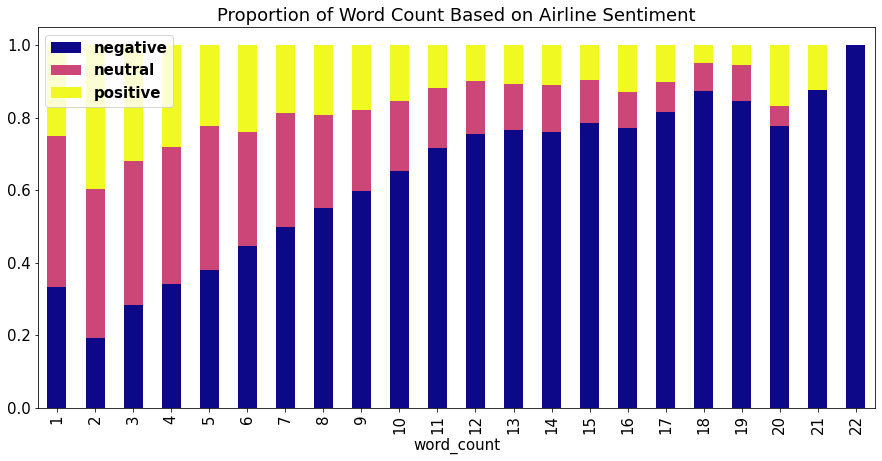

In [15]:
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams.update({'font.size': 15})
plt.rc('legend', fontsize=15)


tweets.groupby('word_count')['airline_sentiment'].value_counts(
    normalize=True).unstack('airline_sentiment').plot.bar(stacked=True, cmap="plasma")
plt.title("Proportion of Word Count Based on Airline Sentiment")

plt.legend(loc="upper right")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)

plt.show()

The negative sentiment has more words in the tweet

## Check the percentage of text that are uppercase

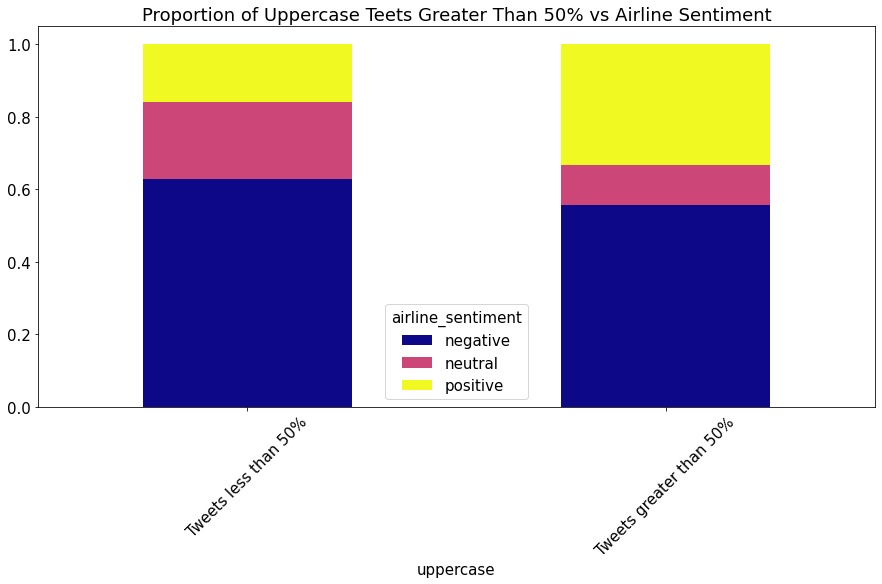

In [16]:
df = tweets[tweets["uppercase"] > 0.50]

ax = tweets.groupby(tweets["uppercase"] > 0.50)['airline_sentiment'].value_counts(
    normalize=True).unstack('airline_sentiment').plot.bar(stacked=True, cmap="plasma")

ax.set_xticklabels(["Tweets less than 50%","Tweets greater than 50%"], rotation = 45)

plt.title("Proportion of Uppercase Teets Greater Than 50% vs Airline Sentiment")
plt.show()

Figure above is the proportion of airline sentiment grouped into whether the tweet is over 50% uppercase (True) or less than 50% (False). Between the two groups, the negative sentiment is roughly the same. The positive sentiment of the tweets that are greater than 50% uppercase has a higher proportion compared to the tweets that are less than 50% uppercase.  I would say that there is not much of a correlation between uppercase tweets and negative airline sentiment based on this dataset.

## Check the proportion of tweets with an emoji in text

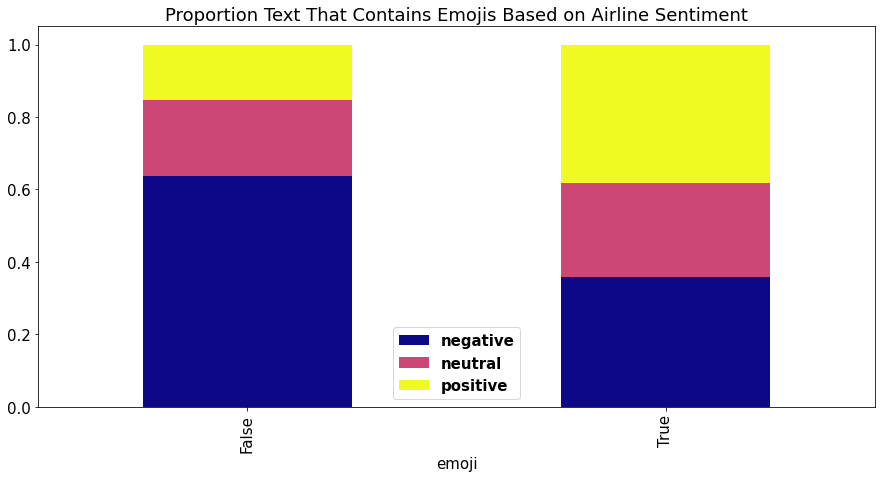

In [17]:
tweets.groupby('emoji')['airline_sentiment'].value_counts(
    normalize=True).unstack('airline_sentiment').plot.bar(stacked=True, cmap="plasma")
plt.title("Proportion Text That Contains Emojis Based on Airline Sentiment")

plt.legend(loc="upper right")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)

plt.show()

 ## Airline Sentiment Proportion

Text(0.5, 1.0, 'Airline Sentiment Proportion')

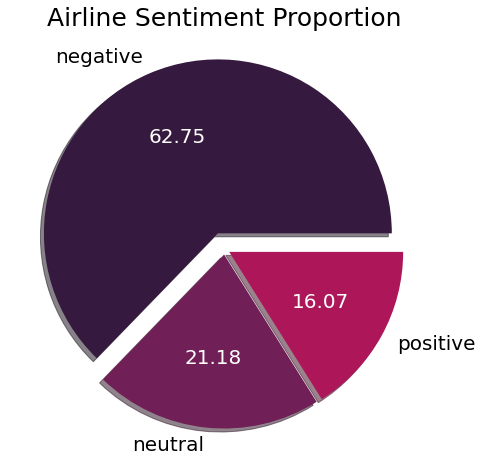

In [18]:
colors= sns.color_palette('rocket')
al = tweets["airline_sentiment"].value_counts()
myexplode = [0.10, 0.03, 0.03]

pie, ax = plt.subplots(figsize=[20,8])
_, _, autotexts = plt.pie(al, labels = al.keys(), colors=colors, autopct="%.2f", 
                          explode = myexplode, shadow=True, textprops={'fontsize': 20})

for ins in autotexts:
    ins.set_color('white')

plt.title("Airline Sentiment Proportion", fontsize=25)

### Most of the sentiments are negative. Let''s view based on each airline.

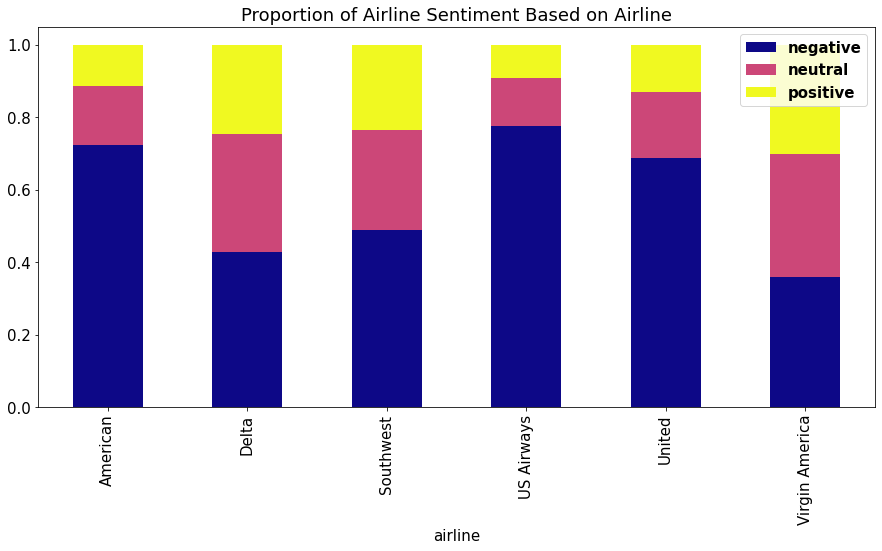

In [19]:
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams.update({'font.size': 15})

tweets.groupby('airline')['airline_sentiment'].value_counts(
    normalize=True).unstack('airline_sentiment').plot.bar(stacked=True, cmap="plasma")
plt.title("Proportion of Airline Sentiment Based on Airline")

plt.legend(loc="upper right")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)

plt.show()

## Proportions of airlines in the dataset

Text(0.5, 1.0, 'Airlines')

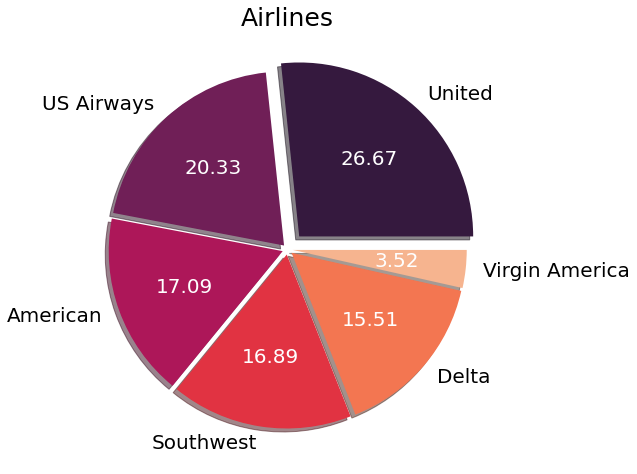

In [20]:
colors= sns.color_palette('rocket')
al = tweets["airline"].value_counts()
myexplode = [0.10, 0.03, 0.03, 0.03, 0.03, 0.03]

pie, ax = plt.subplots(figsize=[20,8])
_, _, autotexts = plt.pie(al, labels = al.keys(), colors=colors, autopct="%.2f", 
                          explode = myexplode, shadow=True, textprops={'fontsize': 20})

for ins in autotexts:
    ins.set_color('white')

plt.title("Airlines", fontsize=25)

## Proportions of airline sentiment or each airline 

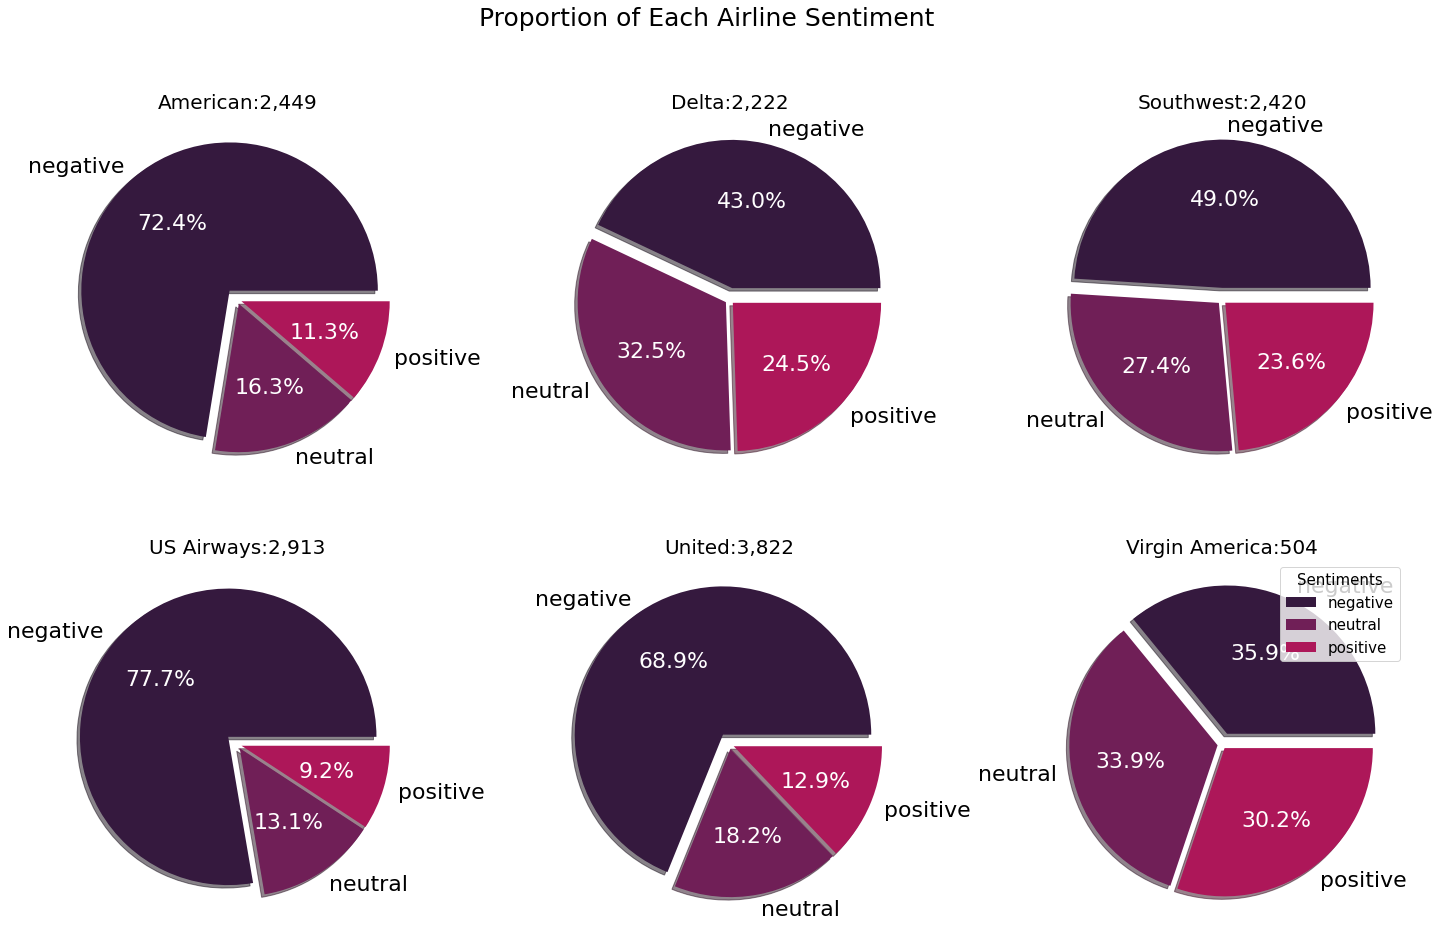

In [21]:
airlines = tweets.groupby(["airline", "airline_sentiment"])["airline_sentiment"].count().unstack()
colors= sns.color_palette('rocket')
myexplode = [0.08, 0.03, 0.03]

fig, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.flatten()

for i, ax in zip(range(0, 6), axes):
    temp = airlines.iloc[i]
    _, _, autotexts = ax.pie(x=temp, labels = temp.index, autopct="%.1f%%", colors=colors, 
           explode = myexplode, shadow = True, textprops={'fontsize': 22})
    ax.set_title(f"{airlines.index[i]}:{format(airlines.values[i].sum(),',')}", fontsize=20)
    for ins in autotexts:
        ins.set_color('white')
    
    
    
plt.suptitle("Proportion of Each Airline Sentiment", fontsize = 25)    
plt.legend(title = "Sentiments")
plt.show()

# <b>Get the most predictive words</b> <a class="anchor" id="pw"></a>


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

tweets["text"] = tweets["text"].astype(str)

cv = CountVectorizer(min_df=50, max_df=0.70)
X = cv.fit_transform(tweets.text)
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)

lr = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)

In [23]:
words = np.array(cv.get_feature_names())

X = np.eye(X_test.shape[1])
probs = lr.predict_log_proba(X)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good Words")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad Words")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good Words
               thank 0.96
                  hi 0.93
              thanks 0.92
             amazing 0.91
             awesome 0.90
                love 0.90
             booking 0.89
                soon 0.89
        confirmation 0.88
               great 0.88
Bad Words
                lost 0.25
                half 0.22
            terrible 0.21
          ridiculous 0.21
               error 0.21
                 fix 0.21
                lack 0.19
                fail 0.18
        disappointed 0.12
               worst 0.08


Method

Preprocess the text
Create term-document matrix with CountVectorizer
Train a predictive model on the matrix
Create an identity matrix the length of the vocabulary - so essentially we are creating a list of documents with the same vocabulary as our CountVectorizer, and each document is one word long - one for each word on the vocabulary
Use your model to predict on the identity matrix, and get a list of probabilities for each word
Connect the vocabulary to the probabilities (you can zip or use np.hstack or make a data frame with 2 columns)
Sort for most/least probable words for any give class
If words don’t make sense, experiment with min_df until they do (often min_df = 50 is good for this) 
you can just list these out, similarly to in the naive bayes assignment, you can also use the word_cloud module and use .generate_from_frequencies() method to create word clouds for most predictive and least predictive words
.generate_from_frequencies() allows you to input a dictionary rather than simply text, so you can input a dictionary with the words as the keys and their probabilities as the values

In [24]:
### make list of words ###
allWords = words[ind]
words = []

for w in allWords:
    w =  "{:>20}".format(w)
    words.append(w)

### make list of prob ###
allProb = probs[ind]
probability = []

for p in allProb:
    p = "{:.2f}".format(1 - np.exp(p))
    probability.append(p)

In [25]:
predictiveWords = {"Words": words, "Probabilities": probability}

predictiveWords = pd.DataFrame(predictiveWords)
predictiveWords.head()

Words Probabilities
0                 thank          0.96
1                    hi          0.93
2                thanks          0.92
3               amazing          0.91
4               awesome          0.90

In [26]:
### top predecticted words ###
predictiveWords[:10]

Words Probabilities
0                 thank          0.96
1                    hi          0.93
2                thanks          0.92
3               amazing          0.91
4               awesome          0.90
5                  love          0.90
6               booking          0.89
7                  soon          0.89
8          confirmation          0.88
9                 great          0.88

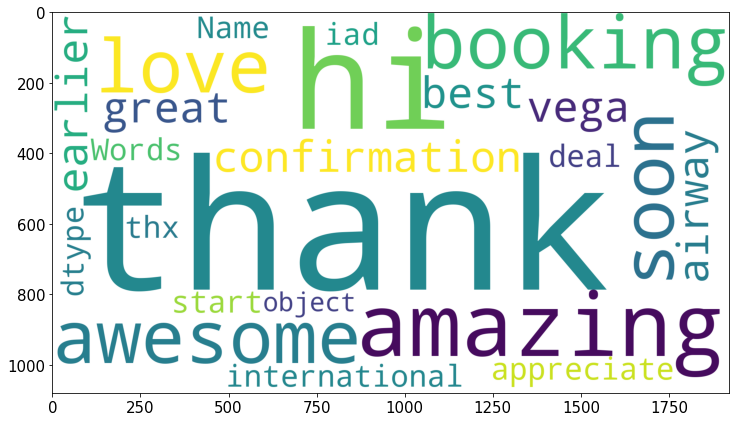

In [27]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

wc = WordCloud(background_color = 'white', width = 1920, height = 1080)
cloud = wc.generate_from_text(str(predictiveWords[:20].Words))
plt.imshow(cloud)
plt.show()

In [28]:
### bottom positive predecticted words ###
predictiveWords[-10:]

Words Probabilities
456                  lost          0.25
457                  half          0.22
458              terrible          0.21
459            ridiculous          0.21
460                 error          0.21
461                   fix          0.21
462                  lack          0.19
463                  fail          0.18
464          disappointed          0.12
465                 worst          0.08

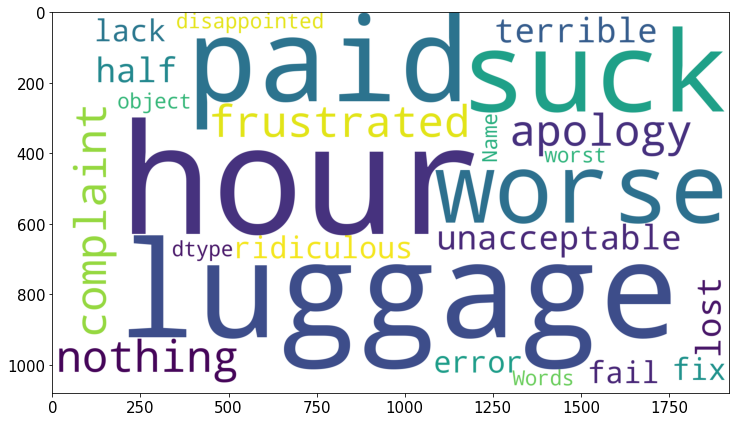

In [29]:
wc = WordCloud(background_color = 'white', width = 1920, height = 1080)
cloud = wc.generate_from_text(str(predictiveWords[-20:].Words))
plt.imshow(cloud)
plt.show()

# Predictive words based on Airlines <a class="anchor" id="pwa"></a>

In [30]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def bad_good_words(airline, min_df):
    
    df = tweets.copy()
    
    df = df[df['airline']==airline]
    
    
    df["text"] = df["text"].astype(str)
    df = df[df["airline_sentiment"] != "neutral"]

    cv = CountVectorizer(min_df=min_df, max_df=0.70)
    X = cv.fit_transform(df.text)
    y = df['airline_sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)
    lr = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)


    words = np.array(cv.get_feature_names())

    X = np.eye(X_test.shape[1])
    probs = lr.predict_log_proba(X)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:10]]
    bad_words = words[ind[-10:]]

    good_prob = probs[ind[:10]]
    bad_prob = probs[ind[-10:]]
    
    df_good = pd.DataFrame(columns = ["good_word", "good_prob"])
    df_bad = pd.DataFrame(columns = ["bad_word", "bad_prob"])

    for w, p in zip(good_words, good_prob):
        df_good = df_good.append({"good_word": w, "good_prob": "{:.3f}".format(1 - np.exp(p))}, ignore_index=True)
    
    for w,p  in zip(bad_words, bad_prob):
        df_bad = df_bad.append({"bad_word": w, "bad_prob": "{:.3f}".format(1 - np.exp(p))}, ignore_index=True)
        
    df_good["good_prob"] = pd.to_numeric(df_good["good_prob"])
    df_bad["bad_prob"] = pd.to_numeric(df_bad["bad_prob"])
    df_bad["bad_prob"] = df_bad["bad_prob"].apply(lambda x: (1-x))
    print(df_bad.sort_values("bad_prob", ascending=False))
    print(df_good.sort_values("good_prob", ascending=False))
    
    fig, axes = plt.subplots(figsize=(15, 5))
    
    sns.barplot(x="bad_word", y="bad_prob", data=df_bad, palette="rocket", 
                     order = df_bad.sort_values("bad_prob", ascending=False).bad_word).set(
                    title="Probability of Negative Words", xlabel ='Words', ylabel ='Probability')
    axes.set_ylim(0, 1.0)

## United

  bad_word  bad_prob
9     hour     0.955
8    worst     0.954
7     want     0.947
6  nothing     0.935
5   doesnt     0.931
4    would     0.923
0      say     0.918
1       im     0.918
2  already     0.918
3    stuck     0.918
    good_word  good_prob
0       thank      0.846
1      thanks      0.775
2       great      0.659
3     amazing      0.596
4        best      0.556
5        good      0.522
6  appreciate      0.504
7        year      0.471
8        made      0.458
9  connecting      0.451


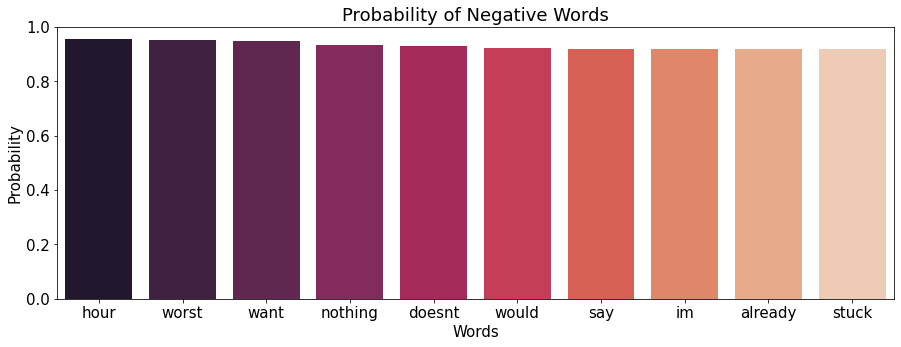

In [31]:
bad_good_words("United", 25)

In [32]:
### function to view specific words ###

def getWordContext(wordList, airline):

    weirdDF =  pd.read_csv("../Data/Tweets.csv")
    pd.set_option("display.max_colwidth", -1)
    weirdDF = weirdDF[weirdDF["airline_sentiment"] != "neutral"]
    weirdDF = weirdDF[weirdDF["airline"] == airline]
    
    query = '|'.join(wordList)
 
    weirdDF['query_match'] = weirdDF["text"].str.contains(query, case=False)
    weirdDF['word'] = weirdDF["text"].str.extract( '({})'.format(query) )
    
    releventTweets = weirdDF[weirdDF["query_match"] == True]

    return releventTweets.head()

In [33]:
weirdWords = ["nothing"]
getWordContext(weirdWords, "United")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_95736/2832750480.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
715  570143097809707008  negative          1.0000                         
744  570105441688158208  negative          0.6492                         
747  570104743747416064  negative          0.6667                         
844  570054574389788672  negative          1.0000                         
929  570005000643956736  negative          1.0000                         

             negativereason  negativereason_confidence airline  \
715  Lost Luggage            1.0000                     United   
744  Lost Luggage            0.6492                     United   
747  Customer Service Issue  0.3542                     United   
844  Customer Service Issue  1.0000                     United   
929  Lost Luggage            1.0000                     United   

    airline_sentiment_gold            name negativereason_gold  retweet_count  \
715  NaN                    8629Fissile     NaN                 0               
744  NaN                    kevinforgoogle  NaN                 0               
747  NaN                    Meyer47         NaN                 0               
844  NaN                    rholbrook       NaN                 0               
929  NaN                    mattscottcrum   NaN                 0               

                                                                                                                                                text  \
715  @united Could you update me on the suitcase please? The online and phone tracking told me nothing. I was told I'd have it back yesterday!         
744  @united But they are not... lady one phone says its in tel aviv. Tel Aviv united says its in Newark. No one knows and I have nothing...           
747  @united what is that going to do for you? Nothing just like you always do                                                                         
844  @united Calls to 800# resulted in 2hrs of hold time &amp; 2day wait to check suspect code share fare. Nothing investigated—my time wasted (2/2)   
929  @united or @flysaa has lost my baggage… heard different things from different employees of @united. @flysaa has said nothing.                     

    tweet_coord              tweet_created     tweet_location  \
715  NaN         2015-02-24 00:48:01 -0800  NaN                 
744  NaN         2015-02-23 22:18:24 -0800  San Francisco, CA   
747  NaN         2015-02-23 22:15:37 -0800  Iowa                
844  NaN         2015-02-23 18:56:16 -0800  Brooklyn, NY        
929  NaN         2015-02-23 15:39:16 -0800  Nashville, TN       

                   user_timezone  query_match     word  
715  London                       True         nothing  
744  NaN                          True         nothing  
747  NaN                          True         NaN      
844  Eastern Time (US & Canada)   True         NaN      
929  Mountain Time (US & Canada)  True         nothing

Several United customers are experiencing late and delayed flights. Some were stuck for several hours before they were able to reach their destination. They also were not able to reach out to customer service to resolve the issue. Some customers were on hold for hours and nothing was resolved. In some incidents customers lost their luggage and had a difficult time recovering them. 


Below are some tweets from customers who have had a negative experience.

1. “@united I tried but no one was available in bogota and everyone was rude in Houston. I was stuck for 35 hours because of you guys”
2. “@united I sure did. I had to drive a total of 3 hours to get my own bag. I'd like to explain that debacle but no one wants to talk to me.”
3. “@united Calls to 800# resulted in 2hrs of hold time &amp; 2day wait to check suspect code share fare. Nothing investigated—my time wasted (2/2”


## American

  bad_word  bad_prob
9  dont     0.959   
8  bag      0.943   
7  baggage  0.942   
5  cant     0.941   
6  hr       0.941   
4  system   0.939   
2  worst    0.938   
3  rep      0.938   
1  need     0.937   
0  hour     0.934   
  good_word  good_prob
0  thank     0.847    
1  thanks    0.718    
2  great     0.696    
3  love      0.601    
4  good      0.470    
5  new       0.364    
6  yes       0.343    
7  keep      0.318    
8  home      0.312    
9  morning   0.296    


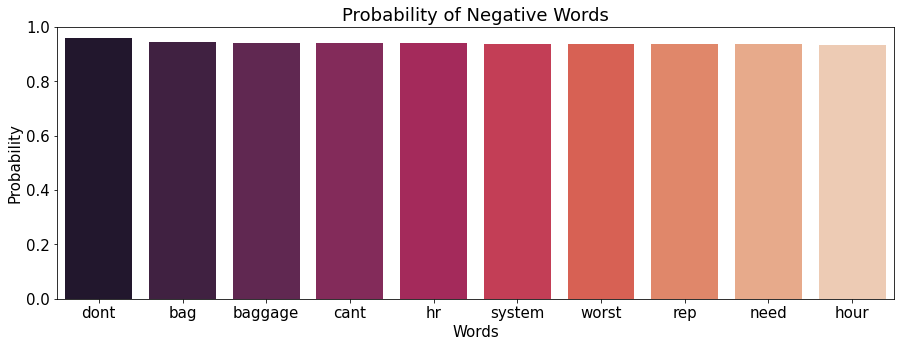

In [34]:
bad_good_words("American", 25)

In [35]:
weirdWords = ["due"]
getWordContext(weirdWords, "American")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_95736/2832750480.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
11890  570306529947193344  negative          0.6449                         
11984  570276196405125120  negative          1.0000                         
12017  570268646544510976  negative          1.0000                         
12051  570306529947193344  negative          1.0000                         
12145  570276196405125120  negative          1.0000                         

                    negativereason  negativereason_confidence   airline  \
11890  longlines                    0.3340                     American   
11984  Late Flight                  1.0000                     American   
12017  Flight Attendant Complaints  0.3475                     American   
12051  Late Flight                  0.3573                     American   
12145  Late Flight                  1.0000                     American   

      airline_sentiment_gold             name negativereason_gold  \
11890  NaN                    TheTPVshow       NaN                  
11984  NaN                    mwecker          NaN                  
12017  NaN                    weezerandburnie  NaN                  
12051  NaN                    TheTPVshow       NaN                  
12145  NaN                    mwecker          NaN                  

       retweet_count  \
11890  0               
11984  0               
12017  0               
12051  0               
12145  0               

                                                                                                                                                     text  \
11890  @AmericanAir I slept in the miami airport due to mechanical issues and was given 10,000 bonus miles to try and make it right. #slapintheface         
11984  @AmericanAir Right. But more than two hours Late Flight, and it seems due to poor communication, which sounded like it was annoying on-plane staff   
12017  @AmericanAir It is now going to be reported to the police due to the sexual assult sad that you didn't care                                          
12051  @AmericanAir I slept in the miami airport due to mechanical issues and was given 10,000 bonus miles to try and make it right. #slapintheface         
12145  @AmericanAir Right. But more than two hours Late Flight, and it seems due to poor communication, which sounded like it was annoying on-plane staff   

      tweet_coord              tweet_created  tweet_location  \
11890  NaN         2015-02-24 11:37:27 -0800  MN               
11984  NaN         2015-02-24 09:36:55 -0800  Washington, DC   
12017  NaN         2015-02-24 09:06:55 -0800  Belle MO         
12051  NaN         2015-02-24 11:37:27 -0800  MN               
12145  NaN         2015-02-24 09:36:55 -0800  Washington, DC   

                    user_timezone  query_match word  
11890  Central Time (US & Canada)  True         due  
11984  Eastern Time (US & Canada)  True         due  
12017  NaN                         True         due  
12051  Central Time (US & Canada)  True         due  
12145  Eastern Time (US & Canada)  True         due

American customers are experiencing a myriad of late flights and customer service issues. Several customers have complained about late flights with a lack of communication from the airline. Some had issues booking and rescheduling their flight. Customers have also experienced rude flight attendants. Some customers had their luggage lost and had a hard time recovering them. Some customers have also experienced items stolen from their luggage.

Below are some tweets from customers who have had a negative experience.

1. “@AmericanAir extremely upset that your baggage handlers decide to go in my luggage and take my belongings”
2. “@AmericanAir but, what I can always rely on when I fly USAir or American is that employees will be rude and unhappy.”
3. “@AmericanAir im tryin to book a flight but cant get ahold of anyone!”
4. “@AmericanAir Right. But more than two hours Late Flight, and it seems due to poor communication, which sounded like it was annoying on-plane staff”


## Delta

    bad_word  bad_prob
9  hour       0.924   
8  delayed    0.883   
7  bag        0.879   
5  cancelled  0.875   
6  delay      0.875   
4  someone    0.868   
3  ive        0.853   
2  still      0.849   
1  late       0.834   
0  plane      0.830   
  good_word  good_prob
0  thanks    0.916    
1  thank     0.826    
2  awesome   0.805    
3  love      0.803    
4  great     0.796    
5  best      0.782    
6  always    0.670    
7  next      0.605    
8  know      0.601    
9  first     0.599    


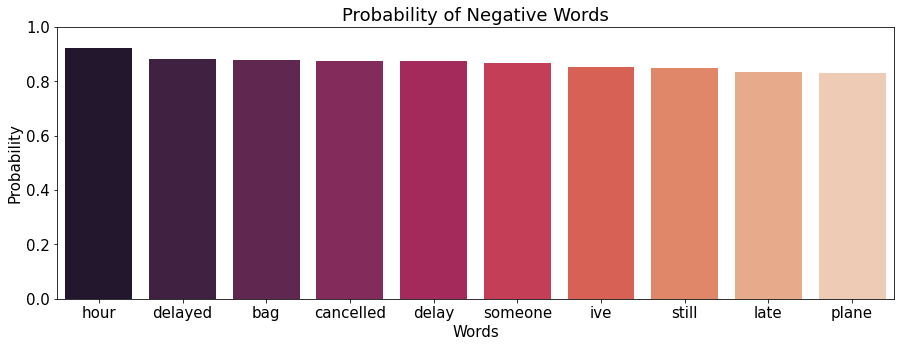

In [36]:
bad_good_words("Delta", min_df=20)

In [37]:
weirdWords = ["bag"]
getWordContext(weirdWords, "Delta")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_95736/2832750480.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
6755  570297402281893888  negative          0.6913                         
6781  570280776849346561  negative          1.0000                         
6855  570173181727674368  negative          1.0000                         
6885  570061375592136706  negative          1.0000                         
7182  569909756493746176  negative          1.0000                         

                   negativereason  negativereason_confidence airline  \
6755  Flight Attendant Complaints  0.3499                     Delta    
6781  Customer Service Issue       0.6630                     Delta    
6855  Customer Service Issue       0.6872                     Delta    
6885  Lost Luggage                 0.6666                     Delta    
7182  Lost Luggage                 0.6415                     Delta    

     airline_sentiment_gold            name negativereason_gold  \
6755  NaN                    chuck_martin    NaN                  
6781  NaN                    YvonneTrimble   NaN                  
6855  NaN                    kerifischer     NaN                  
6885  NaN                    DarthVada_R2D2  NaN                  
7182  NaN                    Dr_Dif          NaN                  

      retweet_count  \
6755  0               
6781  0               
6855  0               
6885  0               
7182  0               

                                                                                                                                              text  \
6755  @JetBlue ’s Marty St. George really has zero clue. How does he still have a job? #nobaggagefees http://t.co/tjDzaMHPEw                         
6781  @JetBlue luggage fees? won't b flying JB again! at least #AA gives platinum pass 2 bags! tired of overchging bg herded like cattle2slaughter   
6855  @JetBlue no seat assignment 5 mins before a flight...line 20 people deep. Guess I'm sitting with the baggage? @MarinaDomine                    
6885  @JetBlue - I did that as soon as I realized. Will they try to figure out who is stealing from people's bags? Security cameras? Anything?       
7182  @JetBlue great job getting flight 28 in 10 minutes early. Too bad we're at 50 minutes and counting waiting for our bags.                       

     tweet_coord              tweet_created         tweet_location  \
6755  NaN         2015-02-24 11:01:10 -0800  SF Bay Area             
6781  NaN         2015-02-24 09:55:07 -0800  Port au Prince, Haiti   
6855  NaN         2015-02-24 02:47:34 -0800  Fort Lauderdale, FL     
6885  NaN         2015-02-23 19:23:17 -0800  NaN                     
7182  NaN         2015-02-23 09:20:49 -0800  USA                     

                   user_timezone  query_match word  
6755  Pacific Time (US & Canada)  True         bag  
6781  Eastern Time (US & Canada)  True         bag  
6855  Central Time (US & Canada)  True         bag  
6885  Atlantic Time (Canada)      True         bag  
7182  NaN                         True         bag

Delta customers have mainly experienced delayed and canceled flights and customer service issues. Customers had trouble contacting customer service to get their issues resolved. Some had to call several times. Customers’ flights were delayed causing issues with their connecting flight. Customers also had lost luggage that they had trouble recovering.  

Below are some tweets from customers who have had a negative experience.

1. “@JetBlue I had to call back five times to get someone on the phone who knew what they were doing. By that time my getaway went up by $200.”
2. “@JetBlue upset with the lack of communication we've received for our "on time" flight 1170 out of MCO”
3. “@JetBlue what is the deal with flt 460 today? Departure keeps changing. When is it going why is it so Late Flight?”
4. “@JetBlue great job getting flight 28 in 10 minutes early. Too bad we're at 50 minutes and counting waiting for our bags.”


## Southwest

    bad_word  bad_prob
9  hour       0.898   
8  someone    0.890   
7  worst      0.888   
6  hold       0.869   
5  luggage    0.866   
4  boarding   0.861   
3  cancelled  0.853   
2  bag        0.850   
1  hr         0.846   
0  online     0.841   
    good_word  good_prob
0  thank       0.907    
1  thanks      0.876    
2  awesome     0.865    
3  best        0.847    
4  crew        0.806    
5  love        0.790    
6  great       0.718    
7  appreciate  0.676    
8  finally     0.660    
9  trip        0.615    


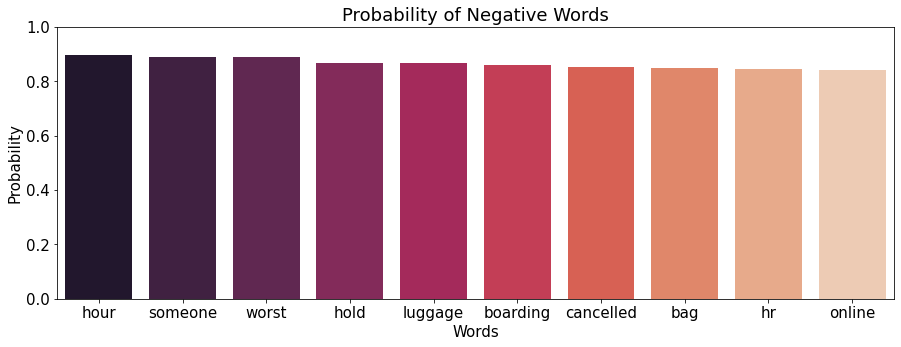

In [38]:
bad_good_words("Southwest", 25)

In [39]:
weirdWords = ["hour"]
getWordContext(weirdWords, "Southwest")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_95736/2832750480.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
4326  570309156290367488  negative          1.000                          
4356  570289521113366531  negative          1.000                          
4362  570287651137445888  negative          1.000                          
4368  570285012882472961  negative          0.627                          
4384  570277221916647425  negative          1.000                          

              negativereason  negativereason_confidence    airline  \
4326  longlines               0.6624                     Southwest   
4356  Late Flight             1.0000                     Southwest   
4362  Lost Luggage            1.0000                     Southwest   
4368  Customer Service Issue  0.6270                     Southwest   
4384  Late Flight             1.0000                     Southwest   

     airline_sentiment_gold           name negativereason_gold  retweet_count  \
4326  NaN                    thisradlove    NaN                 0               
4356  NaN                    Heavenlychc9   NaN                 0               
4362  NaN                    jparkermastin  NaN                 0               
4368  NaN                    Heavenlychc9   NaN                 0               
4384  NaN                    Heavenlychc9   NaN                 0               

                                                                                                                                                    text  \
4326  @SouthwestAir still waiting. Just hit one hour.                                                                                                      
4356  @SouthwestAir oh look you just delayed our flight an additional half hour now arriving at 6 officially five hours after planned. 😡😡😡😡😤😤😤             
4362  @SouthwestAir  got my bags 35 hours Late Flightr and an offer of $50 to go pick them up. Taxi costs $65 one way. Spent $200 for the inconvenience.   
4368  @SouthwestAir have u seen any of the messages the past hour ?                                                                                        
4384  @SouthwestAir and now our arrival is delayed nearly 5hours. Yeah an entire day in an airport is not my idea of a stress less vacation #fail          

     tweet_coord              tweet_created           tweet_location  \
4326  NaN         2015-02-24 11:47:53 -0800  Today I'm in: Maryland    
4356  NaN         2015-02-24 10:29:51 -0800  NaN                       
4362  NaN         2015-02-24 10:22:26 -0800  NaN                       
4368  NaN         2015-02-24 10:11:57 -0800  NaN                       
4384  NaN         2015-02-24 09:40:59 -0800  NaN                       

               user_timezone  query_match  word  
4326  Atlantic Time (Canada)  True         hour  
4356  NaN                     True         hour  
4362  NaN                     True         hour  
4368  NaN                     True         hour  
4384  NaN                     True         hour

Southwest customers are experiencing several customer service issues. Many customers are reaching out to customer service without connecting with someone. Some are being put on hold for several minutes and not being able to connect with a representative in a timely manner. Customers are also stating that if they have to change their reservations, get boarding passes, etc, they have to call customer service instead of doing it online. Several customers have experienced delayed and late flights. Customers are also experiencing lost and damaged luggage. 

Below are some tweets from customers who have had a negative experience.

1. “@SouthwestAir Why can we no longer change trips with a companion online? Been doing it for years, now get message can't be done online?”
2. “@SouthwestAir can you have someone call me back? I have been on hold two times today for over 20 min and still haven't gotten through”
3. “@SouthwestAir got my bags 35 hours Late Flightr and an offer of50𝑡𝑜𝑔𝑜𝑝𝑖𝑐𝑘𝑡ℎ𝑒𝑚𝑢𝑝.𝑇𝑎𝑥𝑖𝑐𝑜𝑠𝑡𝑠65 one way. Spent $200 for the inconvenience.”


## US Airways

  bad_word  bad_prob
9  hour     0.958   
8  hold     0.956   
7  call     0.944   
6  need     0.941   
5  nothing  0.940   
3  luggage  0.936   
4  mile     0.936   
1  never    0.934   
2  reason   0.934   
0  bad      0.932   
    good_word  good_prob
0  thank       0.806    
1  thanks      0.703    
2  great       0.550    
3  awesome     0.537    
4  best        0.510    
5  thx         0.471    
6  away        0.449    
7  kudos       0.443    
8  crew        0.408    
9  appreciate  0.406    


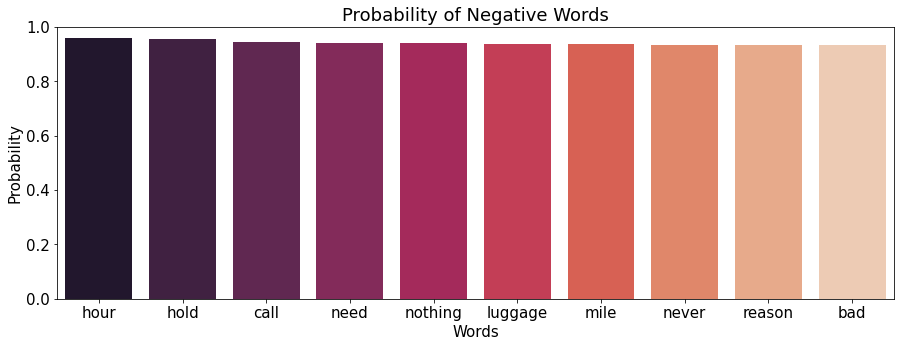

In [40]:
bad_good_words("US Airways", 5)

In [41]:
weirdWords = [ "luggage"]
getWordContext(weirdWords, "US Airways")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_95736/2832750480.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
9070  570251909447192577  negative          1.0                            
9082  570241590758920192  negative          1.0                            
9125  570199481943261184  negative          1.0                            
9136  570157409458642944  negative          1.0                            
9137  570157210183069696  negative          1.0                            

        negativereason  negativereason_confidence     airline  \
9070  Lost Luggage      1.0                        US Airways   
9082  Cancelled Flight  1.0                        US Airways   
9125  Lost Luggage      1.0                        US Airways   
9136  Lost Luggage      1.0                        US Airways   
9137  Lost Luggage      1.0                        US Airways   

     airline_sentiment_gold           name negativereason_gold  retweet_count  \
9070  NaN                    yorkshire2002  NaN                 1               
9082  NaN                    yorkshire2002  NaN                 0               
9125  NaN                    bcruz1028      NaN                 0               
9136  NaN                    yorkshire2002  NaN                 0               
9137  NaN                    yorkshire2002  NaN                 0               

                                                                                                                                                 text  \
9070  @USAirways @Beamske how about a real live person talk to the person whose luggage was lost for 4 days and vacation wrecked . @yorkshire2002       
9082  @USAirways When you are deciding to wreck a vacation... is losing luggage from a Cancelled Flighted flight your "go to" maneuver?                 
9125  @USAirways @AmericanAir Day 3 &amp; still no luggage Chkd http://t.co/MbLTALr4BS STATUS=AWAITING ASGMNT TO DRIVER Since yest 10:15am              
9136  @usairways I will make sure to never use your incompetent airlines again. My luggage has been out for delivery for 24 hours.                      
9137  @usairways My flight was Cancelled Flighted Saturday. Why was my luggage not at the airport? Today, I'm supposed to have it delivered. Pathetic   

     tweet_coord              tweet_created tweet_location  \
9070  NaN         2015-02-24 08:00:24 -0800  Kentucky        
9082  NaN         2015-02-24 07:19:24 -0800  Kentucky        
9125  NaN         2015-02-24 04:32:04 -0800  NaN             
9136  NaN         2015-02-24 01:44:54 -0800  Kentucky        
9137  NaN         2015-02-24 01:44:06 -0800  Kentucky        

                   user_timezone  query_match     word  
9070  Eastern Time (US & Canada)  True         luggage  
9082  Eastern Time (US & Canada)  True         luggage  
9125  NaN                         True         luggage  
9136  Eastern Time (US & Canada)  True         luggage  
9137  Eastern Time (US & Canada)  True         luggage

The cause of negative experiences for US Airways’ customers is mainly customer service issues. Customers have complained about not being able to get in contact with customer service and have been on hold for hours. Some customers are also experiencing being hung up on. Customers are needing to communicate with someone for a variety of needs and they are not able to reach a customer service representative. Customers are also experiencing lost luggage with US Airways. 

Below are some tweets from customers who have had a negative experience.

1. “@USAirways but I've been trying to call them since yesterday and I keep getting hung up on? Can you get me through to them??”
2. “@USAirways I've been on hold to change a date on a ticket for over 3 hours. Can someone please assist me? Unacceptable.”
3. “@USAirways @Beamske how about a real live person talk to the person whose luggage was lost for 4 days and vacation wrecked . @yorkshire2002”


## Virgin America

    bad_word  bad_prob
9  website    0.819   
8  seat       0.765   
7  cancelled  0.692   
6  problem    0.689   
5  help       0.684   
4  customer   0.682   
3  delayed    0.680   
2  check      0.670   
1  week       0.665   
0  jfk        0.641   
  good_word  good_prob
0  love      0.882    
1  thanks    0.839    
2  great     0.825    
3  cool      0.820    
4  best      0.819    
5  route     0.760    
6  thank     0.757    
7  awesome   0.738    
8  virgin    0.731    
9  amazing   0.730    


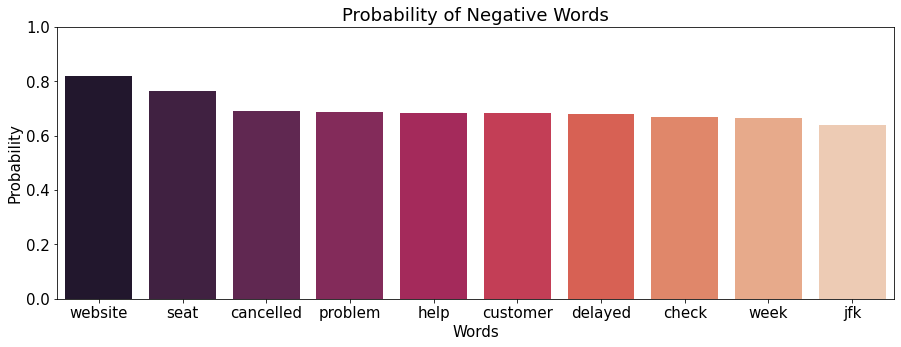

In [42]:
bad_good_words("Virgin America", 7)

In [43]:
weirdWords = [ "check"]
getWordContext(weirdWords, "Virgin America")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_95736/2832750480.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
93   569911674158731264  negative          1.0                            
96   569909224521641984  negative          1.0                            
101  569892199690678272  negative          1.0                            
104  569887310713479168  negative          1.0                            
107  569884407852437504  negative          1.0                            

              negativereason  negativereason_confidence         airline  \
93   Late Flight              1.0000                     Virgin America   
96   Customer Service Issue   0.6771                     Virgin America   
101  Late Flight              0.6882                     Virgin America   
104  Late Flight              0.3486                     Virgin America   
107  Flight Booking Problems  0.6366                     Virgin America   

    airline_sentiment_gold         name negativereason_gold  retweet_count  \
93   NaN                    GunsNDip     NaN                 0               
96   NaN                    ColorCartel  NaN                 0               
101  NaN                    GunsNDip     NaN                 0               
104  NaN                    GunsNDip     NaN                 0               
107  NaN                    BeLeather    NaN                 0               

                                                                                                                                                    text  \
93   @VirginAmerica just landed in LAX, an hour after I should of been here. Your no Late Flight bag check is not business travel friendly #nomorevirgin   
96   @VirginAmerica I can't check in or add a bag. Your website isn't working. I've tried both desktop and mobile http://t.co/AvyqdMpi1Y                   
101  @VirginAmerica why must a traveler miss a flight to Late Flight check a bag?  I missed my morning appointments and you lost my business. #sfo2lax     
104  @VirginAmerica your no Late Flight bag check just lost you my business. I missed flight and AM apt. Three other people on flight had same exp.        
107  @VirginAmerica your site is tripping. I'm trying to check in and I'm getting the plain text version. I am reluctant to enter any card info.           

    tweet_coord              tweet_created tweet_location  \
93   NaN         2015-02-23 09:28:26 -0800  NaN             
96   NaN         2015-02-23 09:18:42 -0800  Austin, TX      
101  NaN         2015-02-23 08:11:03 -0800  NaN             
104  NaN         2015-02-23 07:51:37 -0800  NaN             
107  [0.0, 0.0]  2015-02-23 07:40:05 -0800  NaN             

                   user_timezone  query_match   word  
93   Pacific Time (US & Canada)   True         check  
96   Mountain Time (US & Canada)  True         check  
101  Pacific Time (US & Canada)   True         check  
104  Pacific Time (US & Canada)   True         check  
107  Pacific Time (US & Canada)   True         check

A major issue Virgin America customers are experiencing are flight booking problems and canceled flights. With the flight booking problems, customers are trying to reschedule a flight and are not able to do it online. Several customers have complained about the website being down. Customers are also experiencing canceled flights. With customers’ flights being canceled, it is hard for them to reschedule their flight when Virgin America’s website is down or or has a poor interface.

Below are some tweets from customers who have had a negative experience.

1. “@VirginAmerica Is it me, or is your website down? BTW, your new website isn't a great user experience. Time for another redesign.”
2. “@VirginAmerica How do I reschedule my Cancelled Flightled flights online? The change button is greyed out!”
3. “@VirginAmerica Hey, first time flyer next week - excited! But I'm having a hard time getting my flights added to my Elevate account. Help?”


# Lime

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

df = tweets.copy()
df = df[df["airline_sentiment"] != "neutral"]
df["text"] = df["text"].astype(str)

list_corpus = df["text"].tolist()
list_labels = df["airline_sentiment"].tolist()
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = 'english', binary=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

logreg = LogisticRegression(C=1, max_iter=1000)
logreg.fit(train_vectors, y_train)
pred = logreg.predict(test_vectors)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.909, precision = 0.907, recall = 0.909, f1 = 0.905


In [45]:
c = make_pipeline(vectorizer, logreg)
class_names=list(df.airline_sentiment.unique())
explainer = LimeTextExplainer(class_names=class_names)

idx = 187
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, labels=[1])
print('Document id: %d' % idx)

Document id: 187


In [46]:
#negative sentiment 
print ('Explanation for class %s' % class_names[1])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class negative
('cancelled', -0.04643909886689045)
('usairways', -0.03475262863574722)
('flight', -0.0271885279326798)
('account', -0.02534855552749471)
('getting', -0.017494857501865024)
('flighted', -0.012522711801436102)


In [47]:
#positive sentiment
print ('Explanation for class %s' % class_names[0])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class positive
('cancelled', -0.04643909886689045)
('usairways', -0.03475262863574722)
('flight', -0.0271885279326798)
('account', -0.02534855552749471)
('getting', -0.017494857501865024)
('flighted', -0.012522711801436102)


In [48]:
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, top_labels=2)
print(exp.available_labels())

[0, 1]


In [49]:
exp.show_in_notebook(text=False)

It's predicting that most of the tweets are negative (90%). 

In [50]:
exp.show_in_notebook(text=y_test[idx], labels=(1,))

I zoomed in and study the explanations for class negative as well as the document itself.

### Let's look at the negative reason

Text(0.5, 1.0, 'Negative Reason for Negative Sentiment')

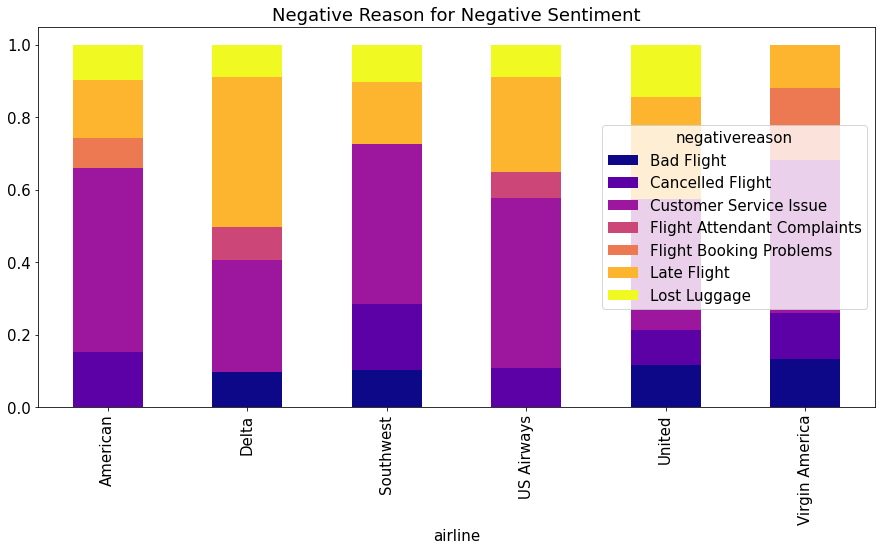

In [51]:
df = tweets[tweets["negativereason"] != "Can't Tell"]
df = df[["airline", "negativereason"]]
df = df.dropna(how='any')

df = df.groupby('airline')["negativereason"].value_counts().rename('count').reset_index()
df = df.groupby('airline').head()


df["percentage"] = df["count"] / df.groupby(["airline"])["count"].transform('sum')

df.pivot_table(index = 'airline', columns = 'negativereason' , values = 'percentage').plot(
    kind = 'bar', stacked = True, cmap="plasma")

plt.title("Negative Reason for Negative Sentiment")

### Date vs Airline Sentiment <a class="anchor" id="Date"></a>

In [52]:
from datetime import datetime

### convert tweet created column to datetime ###
tweets["tweet_created"] = pd.to_datetime(tweets["tweet_created"])

### drop timestmp ###
tweets["tweet_created"] = tweets["tweet_created"].dt.date

###  group by date , airline, and airline sentiment ###
tweetGroup = tweets.groupby(["tweet_created", "airline", "airline_sentiment"]).size()
tweetGroup

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative             1  
                               neutral              1  
               United          negative             2  
2015-02-17     Delta           negative             108
                               neutral              86 
                                                    .. 
2015-02-24     United          neutral              49 
                               positive             25 
               Virgin America  negative             10 
                               neutral              6  
                               positive             13 
Length: 136, dtype: int64

The tweets are between Feb. 16, 2015 and Feb 24, 2015

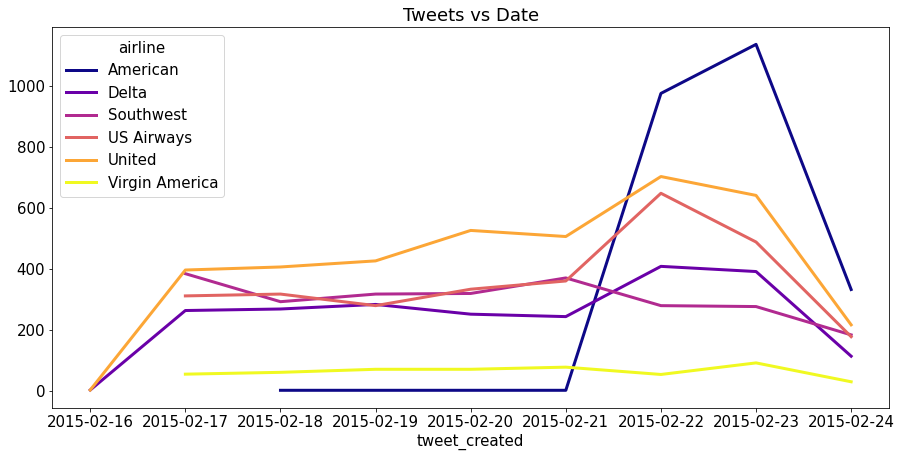

In [53]:
### All tweets per date ###

allTweets = tweets.groupby(["tweet_created", "airline"])["tweet_id"].count()
allTweets.unstack().plot(cmap="plasma", linewidth=3)

plt.title("Tweets vs Date")
plt.show()

In [54]:
### Negative sentiment tweets # 

negTweets = tweets[tweets["airline_sentiment"] == 'negative']
dailySum = negTweets.groupby("tweet_created")["tweet_id"].count() 
dailySum

tweet_created
2015-02-16    3   
2015-02-17    838 
2015-02-18    736 
2015-02-19    751 
2015-02-20    835 
2015-02-21    1049
2015-02-22    2256
2015-02-23    1915
2015-02-24    609 
Name: tweet_id, dtype: int64

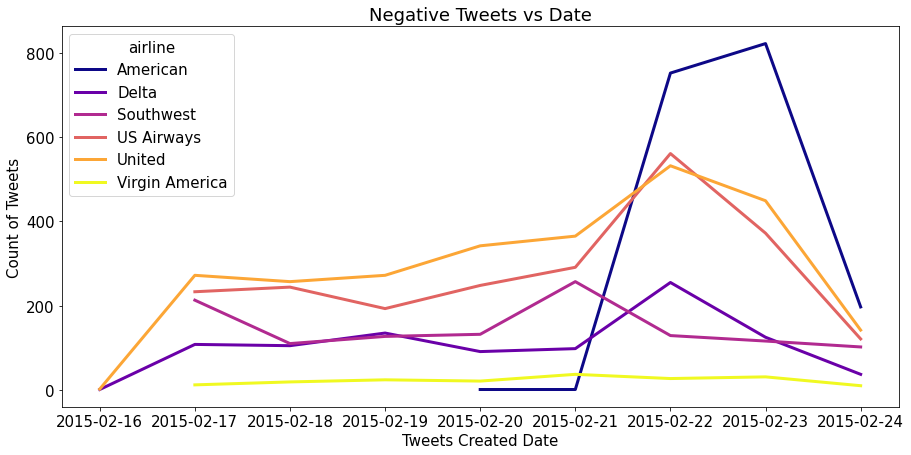

In [55]:
### NEGATIVE TWEETS VS DATE ###
#import matplotlib.ticker as mtick


negTweets = tweets[tweets["airline_sentiment"] == 'negative']
negTweets = negTweets.groupby(["tweet_created", "airline"])["tweet_id"].count()
negTweets.unstack().plot(cmap="plasma", linewidth=3)

plt.title("Negative Tweets vs Date")
plt.xlabel("Tweets Created Date")
plt.ylabel("Count of Tweets")

plt.show()

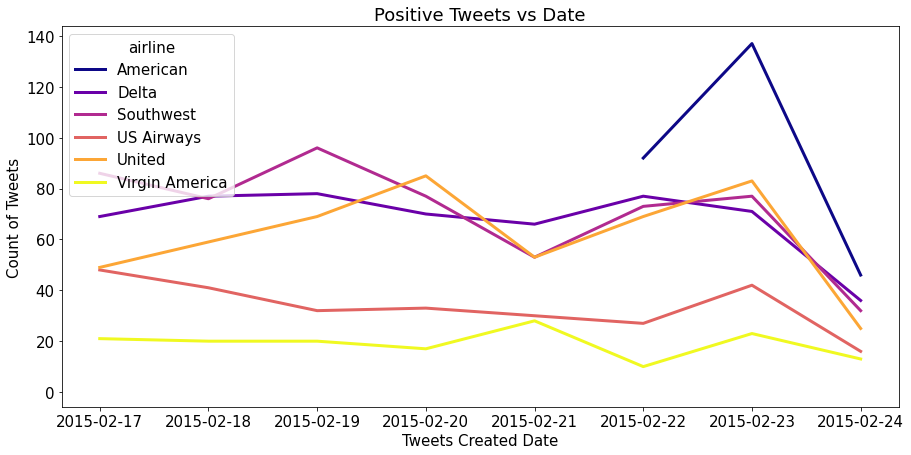

In [56]:
### Positive tweets per date ###

posTweets = tweets[tweets["airline_sentiment"] == 'positive']
posTweets = posTweets.groupby(["tweet_created", "airline"])["tweet_id"].count()
posTweets.unstack().plot(cmap="plasma", linewidth=3)


plt.title("Positive Tweets vs Date")
plt.xlabel("Tweets Created Date")
plt.ylabel("Count of Tweets")
plt.show()


## user_timezone  <a class="anchor" id="user_timezone"></a>

In [57]:
### number of timezones ###
tweets.user_timezone.nunique()

85

In [58]:
topTZ = tweets.user_timezone.value_counts().head(10)
topTZ = topTZ.to_frame()
topTZ = topTZ.reset_index()
topTZ = topTZ.rename(columns={"index": "Timezone", "user_timezone": "Count"})
topTZ.head()

Timezone  Count
0  Eastern Time (US & Canada)  3696 
1  Central Time (US & Canada)  1869 
2  Pacific Time (US & Canada)  1184 
3  Quito                       710  
4  Atlantic Time (Canada)      491

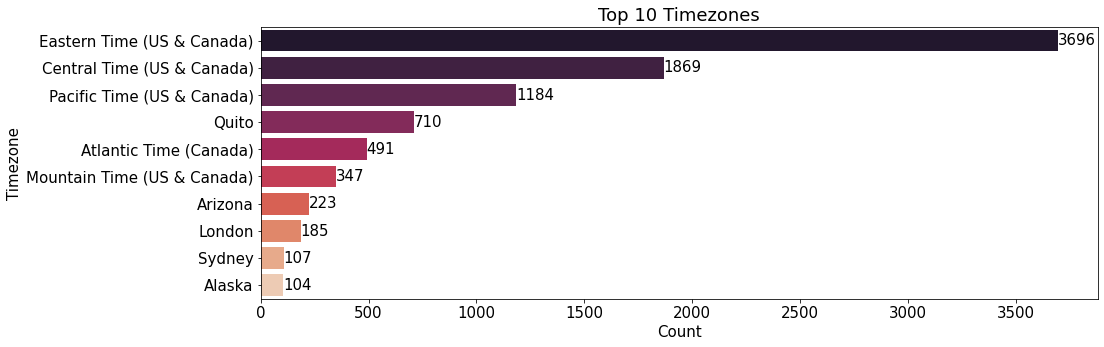

In [59]:
fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.barplot(y = "Timezone", x="Count", data=topTZ, palette="rocket")
plt.title("Top 10 Timezones")

for container in axes.containers:
    axes.bar_label(container)

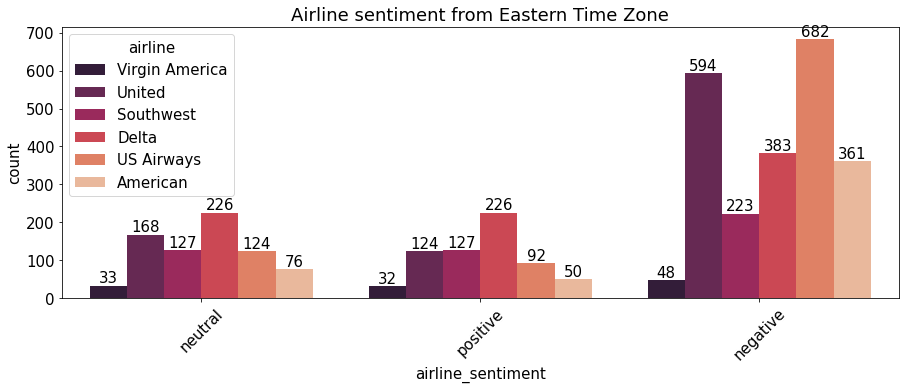

In [60]:
eastTZ = tweets[tweets["user_timezone"] == "Eastern Time (US & Canada)"]

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "airline_sentiment", hue="airline", data=eastTZ, palette="rocket")
plt.title("Airline sentiment from Eastern Time Zone")

plt.xticks(rotation=45)

for container in axes.containers:
    axes.bar_label(container)

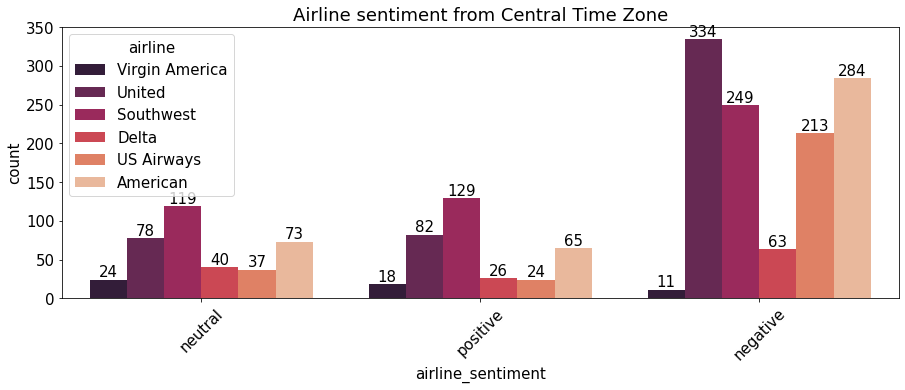

In [61]:
centralTZ = tweets[tweets["user_timezone"] == "Central Time (US & Canada)"]

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "airline_sentiment", hue="airline", data=centralTZ, palette="rocket")
plt.title("Airline sentiment from Central Time Zone")

plt.xticks(rotation=45)

for container in axes.containers:
    axes.bar_label(container)

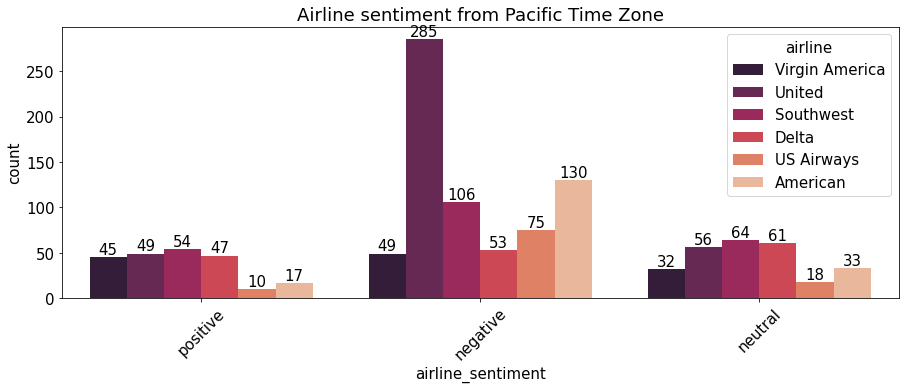

In [62]:
pacificTZ = tweets[tweets["user_timezone"] == "Pacific Time (US & Canada)"]

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "airline_sentiment", hue="airline", data=pacificTZ, palette="rocket")
plt.title("Airline sentiment from Pacific Time Zone")

plt.xticks(rotation=45)

for container in axes.containers:
    axes.bar_label(container)

# Conclusion <a class="anchor" id="Conclusion"></a>

Tracking a sentiment analysis is a way that companies can see what their customers think about their company.

Most of the the sentiment are negative.

#### Reasons for negative sentiment

Delta, American, US Airways, and United top complaints are customer service issue and late flight.

Virgin America top complaints are customer service issues and flight booking problems. 

Southwest top complaints are customer service issues and cancelled flights.

#### Time Zone vs Airline Sentiment 

There's not really a correlation between timezone and airline sentiment. 

#### Date vs Airline Sentiment
The tweets are from Feb 16 - Feb 24. There are simply not enough days to make an observation.
